In [1]:
%matplotlib inline

import os
import statistics
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [2]:
PROCESSED_DATA_PATH = '../oct-data/data-1'

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
class OctSliceDataset(Dataset):
    def __init__(self, split, slice_idx=99):
        assert 0 <= slice_idx < 200
        self.slice_idx = slice_idx
        
        pos_dir = os.path.join(PROCESSED_DATA_PATH, 'pos')
        pos_paths = [os.path.join(pos_dir, f) for f in os.listdir(pos_dir) if self.split(split, f)]
        
        neg_dir = os.path.join(PROCESSED_DATA_PATH, 'neg')
        neg_paths = [os.path.join(neg_dir, f) for f in os.listdir(neg_dir) if self.split(split, f)]
        
        self.cube_paths = pos_paths + neg_paths
        self.labels = [1.] * len(pos_paths) + [0.] * len(neg_paths)
        
        self.transforms = T.Compose([
            T.Resize([200, 200]),
            T.ToTensor()
        ])
        
        assert len(self.labels) == len(self.cube_paths)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, i):
        cube = np.load(self.cube_paths[i])
        label = self.labels[i]
        
        slice_ = cube[:, :, self.slice_idx]
        img = Image.fromarray(slice_)
        return torch.tensor(self.transforms(img)), torch.tensor(label)
    
    def split(self, split, f):
        if split == 'train':
            return hash(f) % 10 >= 2
        elif split == 'val':
            return hash(f) % 10 == 1
        elif split == 'test':
            return hash(f) % 10 == 0
        else:
            raise ValueError('invalid split')

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

class OctSliceNet(nn.Module):
    def __init__(self):
        super(OctSliceNet, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            Flatten(),
            nn.Linear(8464, 1)
        )
        self.optimizer = torch.optim.Adam(self.parameters())
        self.loss_fn = nn.BCEWithLogitsLoss()
    
    def forward(self, slice_):
        return self.cnn(slice_).squeeze(dim=1)
    
    def train_step(self, slice_, targets):
        logits = self(slice_)
        loss = self.loss_fn(logits, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss

In [6]:
def evaluate(net, loader, verbose=True):
    start = time.time()
    all_logits = []
    all_labels = []
    all_losses = []

    with torch.no_grad():
        for i, (X, y) in enumerate(loader):
            logits = net(X.to(device))
            loss = net.loss_fn(logits, y.to(device))
            all_logits.extend(list(logits.cpu().numpy()))
            all_labels.extend(list(y))
            all_losses.append(loss.item())

    val_loss = statistics.mean(all_losses)
    auprc = average_precision_score(all_labels, all_logits)
    auroc = roc_auc_score(all_labels, all_logits)
    
    if verbose:
        print(f'Average precision score: {auprc}')
        print(f'AUROC: {auroc}')
        print(f'Validation loss (approximate): {val_loss}')
        print(f'Elapsed: {time.time() - start}')
    return val_loss, auprc, auroc

In [7]:
def train_with_slice(slice_idx, num_epochs=10, verbose=True):
    print('==============')
    print(f'Training with slice index: {slice_idx}')
    
    train_dataset = OctSliceDataset('train', slice_idx)
    val_dataset = OctSliceDataset('val', slice_idx)
    test_dataset = OctSliceDataset('test', slice_idx)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8)

    net = OctSliceNet().to(device)

    if verbose: print('------ Evaluating ------')
    evaluate(net, val_loader, verbose)
    for epoch in range(1, num_epochs + 1):
        if verbose: print(f'====== Epoch {epoch} ======')
        losses = []
        for X, y in train_loader:
            loss = net.train_step(X.to(device), y.to(device))
            loss = loss.item()
            losses.append(loss)
        train_loss = statistics.mean(losses)
        if verbose: print(f'Train loss (approximate): {train_loss}')

        if verbose: print('------ Evaluating ------')
        val_loss, auprc, auroc = evaluate(net, val_loader, verbose)
        
    return train_loss, val_loss, auprc, auroc

In [8]:
slice_idxs = [0, 25, 50, 75, 100, 125, 150, 175, 199]
train_losses = []
val_losses = []
auprcs = []
aurocs = []

for slice_idx in slice_idxs:
    train_loss, val_loss, auprc, auroc = train_with_slice(slice_idx)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    auprcs.append(auprc)
    aurocs.append(auroc)

Training with slice index: 0
------ Evaluating ------
Average precision score: 0.6047157078974936
AUROC: 0.5022727272727272
Validation loss (approximate): 0.7156466910472283
Elapsed: 4.190261125564575
====== Epoch 1 ======
Train loss (approximate): 0.8903922325855976
------ Evaluating ------
Average precision score: 0.6244568263103595
AUROC: 0.5784090909090909
Validation loss (approximate): 0.7718120973843795
Elapsed: 1.0217993259429932
====== Epoch 2 ======
Train loss (approximate): 0.7251674935624406
------ Evaluating ------
Average precision score: 0.5705589711624726
AUROC: 0.4962121212121212
Validation loss (approximate): 0.7145768220608051
Elapsed: 0.872255802154541
====== Epoch 3 ======
Train loss (approximate): 0.7087486968921112
------ Evaluating ------
Average precision score: 0.5151335162636023
AUROC: 0.45189393939393935
Validation loss (approximate): 0.7488335141768823
Elapsed: 0.8981950283050537
====== Epoch 4 ======
Train loss (approximate): 0.6861874318874635
------ Evalu

Train loss (approximate): 0.6907553911746085
------ Evaluating ------
Average precision score: 0.6769133451383585
AUROC: 0.6890151515151516
Validation loss (approximate): 0.6639360326987046
Elapsed: 0.8651559352874756
====== Epoch 3 ======
Train loss (approximate): 0.6681985892691054
------ Evaluating ------
Average precision score: 0.538169424047467
AUROC: 0.4590909090909091
Validation loss (approximate): 0.8304518254903647
Elapsed: 0.8895456790924072
====== Epoch 4 ======
Train loss (approximate): 0.6771826663532773
------ Evaluating ------
Average precision score: 0.6048567724242901
AUROC: 0.5901515151515151
Validation loss (approximate): 0.7393919710929577
Elapsed: 0.8992352485656738
====== Epoch 5 ======
Train loss (approximate): 0.6403528653286599
------ Evaluating ------
Average precision score: 0.6654923900827034
AUROC: 0.6909090909090909
Validation loss (approximate): 0.6849267757855929
Elapsed: 0.9146347045898438
====== Epoch 6 ======
Train loss (approximate): 0.6140991916527

Train loss (approximate): 0.6785606521743912
------ Evaluating ------
Average precision score: 0.6003328916768199
AUROC: 0.49886363636363634
Validation loss (approximate): 0.7339594960212708
Elapsed: 0.8627147674560547
====== Epoch 5 ======
Train loss (approximate): 0.6548051221950634
------ Evaluating ------
Average precision score: 0.6234817758951519
AUROC: 0.5859848484848484
Validation loss (approximate): 0.7164953947067261
Elapsed: 0.8698074817657471
====== Epoch 6 ======
Train loss (approximate): 0.6466968287755778
------ Evaluating ------
Average precision score: 0.6178449255702728
AUROC: 0.5674242424242424
Validation loss (approximate): 0.7575437885064346
Elapsed: 0.8699803352355957
====== Epoch 7 ======
Train loss (approximate): 0.5981261112668492
------ Evaluating ------
Average precision score: 0.6637377429090745
AUROC: 0.6215909090909091
Validation loss (approximate): 0.7078741376216595
Elapsed: 0.8694050312042236
====== Epoch 8 ======
Train loss (approximate): 0.55625959264

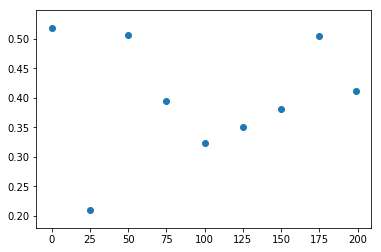

In [9]:
plt.scatter(slice_idxs, train_losses)

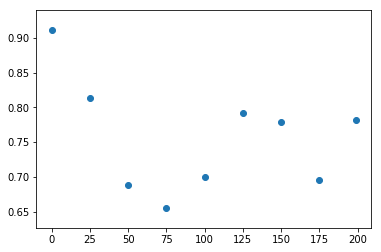

In [10]:
plt.scatter(slice_idxs, val_losses)

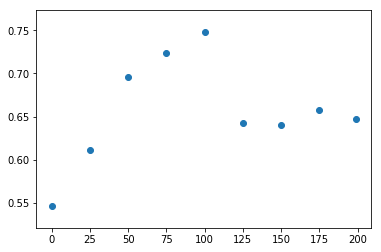

In [11]:
plt.scatter(slice_idxs, auprcs)

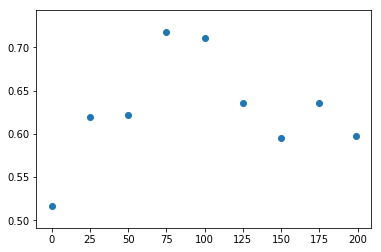

In [12]:
plt.scatter(slice_idxs, aurocs)